# AWS Machine Learning Engineer Nano Degree Capstone Project 

## Plants Disease Detection Using Deep Learning

### Project  Overview

Plant diseases are one of the major factors responsible for substantial losses in yield of
plants, leading to huge economic losses. According to a study by the Associated Chambers
of Commerce and Industry of India, annual crop losses due to diseases and pest’s amount to
Rs.50,000 crore in India alone, which is significant in a country where the
farmers are responsible for feeding a population of close to 1.3 billion people. The value of
plant science is therefore huge.</br>
Accurate identification and diagnosis of plant diseases are very important in the era of
climate change and globalization for food security. Accurate and early identification of plant
diseases could help in the prevention of spread of invasive pests/pathogens. In addition, for an
efficient and economical management of plant diseases accurate, sensitive and specific
diagnosis is necessary.</br>
The growth of GPU’s ( Graphical Processing Units ) has aided academics and business
in the advancement of Deep Learning methods, allowing them to explore deeper and more
sophisticated Neural Networks. Using concepts of Image Classification and Transfer
Learning we could train a Deep Learning model to categorize Plant leaf’s images to predict
whether the plant is healthy or has any diseases. This could help in the early detection of any
diseases in plants and could help take preventive measures to prevent huge crop losses

### Notebook Overview:
This notebook walks through implementation of  Image Classification Machine Learning Model to classify between 9 plant classes ( diseased and healthy )

* We will be using a pretrained Resnet50  model from pytorch vision library (https://pytorch.org/vision/master/generated/torchvision.models.resnet50.html)
* We will be adding in Fully connected Neural network Layers on top of the above Resnet50 model.
* Note: We will be using concepts of Transfer learning and so we will be freezing all the exisiting Convolutional layers in the pretrained resnet50 model and only changing gradients for the tow fully connected layers that we have added.
* Then we will perform Hyperparameter tuning, to help figure out the best hyperparameters to be used for our model.
* Next we will be using the best hyperparameters and fine-tuning our Resent50 model.
* We will also be adding in configuration for Profiling and Debugging our training mode by adding in relevant hooks in the Training and Testing( Evaluation) phases.
* Next we will be deploying our model. While deploying we will create our custom inference script. The custom inference script will be overriding a few functions that will be used by our deployed endpoint for making inferences/predictions.
* Finally we will be testing out our model with some test images of plants, to verfiy if the model is working as per our expectations.

### Data Prepation

####  Installing Libraries
* We will be using **split-folders** to split our dataset into train, val and test sets.
* **tqdm** will help give us a visual status of the progress while copying folders.

In [1]:
!pip install split-folders tqdm

In [25]:
!pip install torchmetrics

     |████████████████████████████████| 396 kB 22.1 MB/s            


#### Download the zipped dataset file from S3.

In [2]:
!aws s3 cp s3://sagemaker-us-east-1-970845818811/CapstoneProposal.zip ./

download: s3://sagemaker-us-east-1-970845818811/CapstoneProposal.zip to ./CapstoneProposal.zip


In [3]:
# lets write a small utility functions to unzip our folder's contents.
import zipfile

# Function below unzips the archive to the local directory. 
def unzip_data(input_data_path):
    with zipfile.ZipFile(input_data_path, 'r') as input_data_zip:
        input_data_zip.extractall('.')

In [4]:
zipped_filename = "CapstoneProposal.zip"
unzip_data(zipped_filename)

In [7]:
input_folder_path = "./CapstoneProposal/dataset/Plant_leave_diseases_dataset_with_augmentation"

##### Quick Overview of the plant diesease dataset.
The total plant disease dataset of that will be used for this project consists of **9644 images** . All the images
vary in dimensions, they are not standardized, and they are all coloured images. So the model
will be trained on the above 9 plant image classes, for our use-case.

#### Splitting Dataset into Train, Validation and Test Sets

The Dataset consists of **9 classes** and the dataset is more or less **balanced**. Thus we can split the dataset into train , validation and test sets in the ratio/proportion of 
**80:10:10**. Meaning 80% training dataset, 10% validation dataset and 10% test dataset.

In [6]:
import splitfolders  # or import split_folders
# Split with a ratio.
splitfolders.ratio(input_folder_path, output="plant_disease_dataset", seed=1357, ratio=(.8, .1, .1), group_prefix=None) # default valuesb

Copying files: 9644 files [00:01, 7263.13 files/s]


#### Uploading the split datset onto S3 bucket.

In [21]:
!aws s3 cp plant_disease_dataset s3://sagemaker-us-east-1-970845818811/plant_disease_dataset --recursive > /dev/null 

#### Exploratory Visualizations

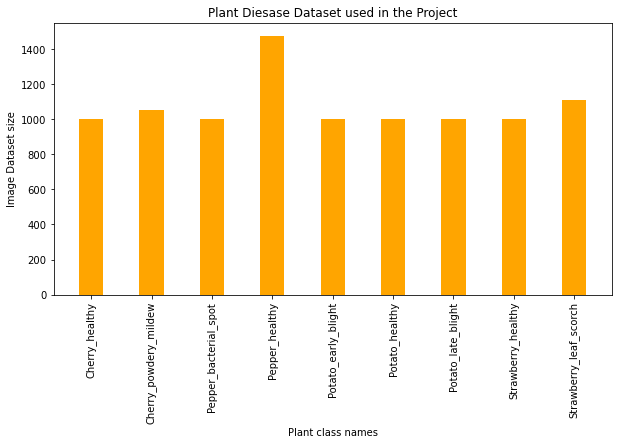

In [14]:
import numpy as np
import matplotlib.pyplot as plt
dataset_images_count = [1001, 1053 ,1000 ,1478 ,1000, 1001, 1000,1001 ,1110 ]
plant_class =[ 'Cherry_healthy' ,'Cherry_powdery_mildew','Pepper_bacterial_spot','Pepper_healthy', 'Potato_early_blight', 
              'Potato_healthy', 'Potato_late_blight', 'Strawberry_healthy', 'Strawberry_leaf_scorch']

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(plant_class, dataset_images_count, color ='orange',
        width = 0.4 )
plt.xticks(rotation=90)
plt.xlabel("Plant class names")
plt.ylabel("Image Dataset size")
plt.title("Plant Diesase Dataset used in the Project")
plt.savefig("Dataset Bar Graph.jpg")
plt.show()

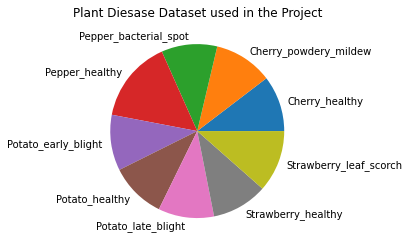

In [16]:
 # creating the pie chart
plt.pie( dataset_images_count, labels = plant_class)
plt.title("Plant Diesase Dataset used in the Project")
plt.savefig("Dataset Pie Chart.jpg")
plt.show()

In [7]:
# For instance, you will need the smdebug package
!pip install smdebug

In [4]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role
# Initializing some useful variables
role = get_execution_role()
sagemaker_session = sagemaker.Session()
region = sagemaker_session.boto_region_name
bucket = sagemaker_session.default_bucket()
print(f"Region {region}")
print(f"Default s3 bucket : {bucket}")

Region us-east-1
Default s3 bucket : sagemaker-us-east-1-970845818811


In [8]:
#adding here only for rerun purposes ( to avoid uploading the inputs again)
inputs = 's3://sagemaker-us-east-1-970845818811/plant_disease_dataset/'
print(f"Input path ( S3 file path ): {inputs}")

Input path ( S3 file path ): s3://sagemaker-us-east-1-970845818811/plant_disease_dataset/


### Training on the Dataset with Default Hyperparmeter Values

In [11]:
from sagemaker.pytorch import PyTorch
# Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py", #this was now been renamed to "train_model_no_metrics.py" , as we added another train_model.py in "code folder" that does calc all Metrics
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.6", #using 1.6 as it has support for smdebug lib , https://github.com/awslabs/sagemaker-debugger#debugger-supported-frameworks
    py_version="py36"
)

estimator.fit({'train' : inputs },wait=True)

2022-01-23 11:49:16 Starting - Starting the training job...
2022-01-23 11:49:38 Starting - Launching requested ML instancesProfilerReport-1642938555: InProgress
......
2022-01-23 11:50:39 Starting - Preparing the instances for training.........
2022-01-23 11:51:59 Downloading - Downloading input data.........
2022-01-23 11:53:39 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-23 11:53:53,359 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-23 11:53:53,381 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-23 11:53:54,042 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-01-23 11:53:54,415 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "train": 

Training the model on the Default Hyperparameter configurations gave us an accuracy of **11%** on the **test set**, which is very low!!!
Default Configs:

* Epochs = 2
* Learning Rate: 0.01
* Batch Size: 64


## Hyperparameter Tuning

* The ResNet50 model with a two Fully connected Linear NN layer's is used for this image classification problem. ResNet-50 is 50 layers deep and is trained on a million images of 1000 categories from the ImageNet database. Furthermore the model has a lot of trainable parameters, which indicates a deep architecture that makes it better for image recognition
* The optimizer that we will be using for this model is AdamW ( For more info refer : https://pytorch.org/docs/stable/generated/torch.optim.AdamW.html )
* Hence, the hyperparameters selected for tuning were:
  * **Learning rate** - default(x)  is 0.001 , so we have selected 0.01x to 1x range for the learing rate
  * **Batch size** -- selected only two values [ 64, 128 ] 
  * **Epochs** -- selected two values [5, 10] as in one of the benchmark papers they achieved good accuracy in 4 epochs.

In [16]:
#Importing all the required modules fomr tuner
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner
)

# We wil be using AdamW as an optimizer which uses a different( more correct or better) way to calulate the weight decay related computations
# So we will be using weight_decay and eps hyperparamter tuning as well , along with the lerning rate and batchsize params
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.0001, 0.001),
    "batch_size": CategoricalParameter([ 64, 128]),
    "epochs": CategoricalParameter([5,10])
}
objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [17]:
from  sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point = "hpo_tuning.py",
    base_job_name = "plant-disease-classification-hpo",
    role = role,
    instance_count = 1,
    instance_type = "ml.g4dn.xlarge",
    py_version = "py36",
    framework_version = "1.8"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=8,
    max_parallel_jobs=2,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

In [18]:
tuner.fit({"training": inputs }, wait=True)

...........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [21]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-01-23 12:38:16 Starting - Preparing the instances for training
2022-01-23 12:38:16 Downloading - Downloading input data
2022-01-23 12:38:16 Training - Training image download completed. Training in progress.
2022-01-23 12:38:16 Uploading - Uploading generated training model
2022-01-23 12:38:16 Completed - Training job completed


{'_tuning_objective_metric': '"average test loss"',
 'batch_size': '"64"',
 'epochs': '"5"',
 'lr': '0.00033327270100541676',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"plant-disease-classification-hpo-2022-01-23-12-10-56-079"',
 'sagemaker_program': '"hpo_tuning.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-970845818811/plant-disease-classification-hpo-2022-01-23-12-10-56-079/source/sourcedir.tar.gz"'}

In [23]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'lr': best_estimator.hyperparameters()['lr'],
                      'epochs': best_estimator.hyperparameters()['epochs'].replace('"', ""),
                      }
print(f"Best Hyperparamters post Hyperparameter fine tuning are : \n {best_hyperparameters}")

Best Hyperparamters post Hyperparameter fine tuning are : 
 {'batch_size': 64, 'lr': '0.00033327270100541676', 'epochs': '5'}


## Finetuning the ML Model

### Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model



In [46]:
# Setting up debugger and profiler rules and configs
from sagemaker.debugger import (
    Rule,
    rule_configs, 
    ProfilerRule,
    DebuggerHookConfig,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile
)


rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

debugger_config=DebuggerHookConfig( collection_configs=collection_configs )

In [47]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    source_dir = "code",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.6", #using 1.6 as it has support for smdebug lib , https://github.com/awslabs/sagemaker-debugger#debugger-supported-frameworks
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

estimator.fit({'train' : inputs },wait=True)

2022-01-24 07:46:58 Starting - Starting the training job...
2022-01-24 07:47:22 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-01-24 07:48:22 Starting - Preparing the instances for training.........
2022-01-24 07:49:50 Downloading - Downloading input data.........
2022-01-24 07:51:22 Training - Downloading the training image...
2022-01-24 07:51:51 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-24 07:51:43,874 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-24 07:51:43,895 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-24 07:51:43,901 sagemaker_pytorch_container.training INFO     Invoking user training scr

## Plot Confusion Matrix the was obtained from the Training Jobs Logs.

In [11]:
class_names = [    
'Cherry_healthy'
,'Cherry_powdery_mildew'
,'Pepper_bacterial_spot'
,'Pepper_healthy'
,'Potato_early_blight'
,'Potato_healthy'
,'Potato_late_blight'
,'Strawberry_healthy'
,'Strawberry_leaf_scorch'
]

In [74]:
#Taking the confusion matrix from the last Testing epoch for visualization purposes.
import numpy as np

test_confusion_matrix = np.array([[105,   0,   0,   0,   0,   1,   0,   0,   0],
        [  1,  99,   0,   1,   0,   0,   0,   0,   0],
        [  1,   0,  93,   6,   0,   0,   0,   0,   0],
        [  1,   0,   6, 142,   0,   0,   0,   0,   0],
        [  0,   0,   1,   0,  97,   2,   0,   0,   0],
        [  1,   0,   0,   0,   5,  93,   0,   1,   0],
        [  5,   2,   1,   2,   2,  17,   0,  62,  10],
        [  1,   1,   0,   0,   0,   2,   0, 107,   0],
        [  0,   3,   2,   0,   1,   0,   0,   1,  94]])
test_confusion_matrix_norm = np.array([[0.9906, 0.0000, 0.0000, 0.0000, 0.0000, 0.0094, 0.0000, 0.0000, 0.0000],
        [0.0099, 0.9802, 0.0000, 0.0099, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0100, 0.0000, 0.9300, 0.0600, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0067, 0.0000, 0.0403, 0.9530, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0100, 0.0000, 0.9700, 0.0200, 0.0000, 0.0000, 0.0000],
        [0.0100, 0.0000, 0.0000, 0.0000, 0.0500, 0.9300, 0.0000, 0.0100, 0.0000],
        [0.0495, 0.0198, 0.0099, 0.0198, 0.0198, 0.1683, 0.0000, 0.6139, 0.0990],
        [0.0090, 0.0090, 0.0000, 0.0000, 0.0000, 0.0180, 0.0000, 0.9640, 0.0000],
        [0.0000, 0.0297, 0.0198, 0.0000, 0.0099, 0.0000, 0.0000, 0.0099, 0.9307]] )

In [75]:
#Taking the confusion matrix from the last Testing epoch for visualization purposes.
import numpy as np

val_confusion_matrix = np.array([[104,   0,   0,   0,   0,   1,   0,   0,   0],
        [  0,  99,   0,   0,   0,   0,   0,   0,   1],
        [  1,   1,  93,   3,   1,   1,   0,   0,   0],
        [  0,   1,   4, 141,   0,   1,   0,   0,   0],
        [  1,   0,   1,   1,  96,   1,   0,   0,   0],
        [  0,   0,   1,   1,   3,  95,   0,   0,   0],
        [  6,   7,   0,   5,   4,  10,   0,  62,   6],
        [  1,   0,   0,   0,   2,   0,   0, 108,   0],
        [  1,   0,   2,   1,   0,   0,   0,   0,  96]])
val_confusion_matrix_norm = np.array([[0.9905, 0.0000, 0.0000, 0.0000, 0.0000, 0.0095, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9900, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0100],
        [0.0100, 0.0100, 0.9300, 0.0300, 0.0100, 0.0100, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0068, 0.0272, 0.9592, 0.0000, 0.0068, 0.0000, 0.0000, 0.0000],
        [0.0100, 0.0000, 0.0100, 0.0100, 0.9600, 0.0100, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0100, 0.0100, 0.0300, 0.9500, 0.0000, 0.0000, 0.0000],
        [0.0600, 0.0700, 0.0000, 0.0500, 0.0400, 0.1000, 0.0000, 0.6200, 0.0600],
        [0.0090, 0.0000, 0.0000, 0.0000, 0.0180, 0.0000, 0.0000, 0.9730, 0.0000],
        [0.0100, 0.0000, 0.0200, 0.0100, 0.0000, 0.0000, 0.0000, 0.0000, 0.9600]] )

In [76]:
# Define a small utility function
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          is_normalized = False,
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import numpy as np
    import itertools
    
    print(cm)

    plt.figure(dpi=120)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation =90 ,fontsize=7)
    plt.yticks(tick_marks, classes, fontsize=7)

    fmt = '.2f' if is_normalized else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=8)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(title+".jpg")

### Confusion Matrix

[[105   0   0   0   0   1   0   0   0]
 [  1  99   0   1   0   0   0   0   0]
 [  1   0  93   6   0   0   0   0   0]
 [  1   0   6 142   0   0   0   0   0]
 [  0   0   1   0  97   2   0   0   0]
 [  1   0   0   0   5  93   0   1   0]
 [  5   2   1   2   2  17   0  62  10]
 [  1   1   0   0   0   2   0 107   0]
 [  0   3   2   0   1   0   0   1  94]]


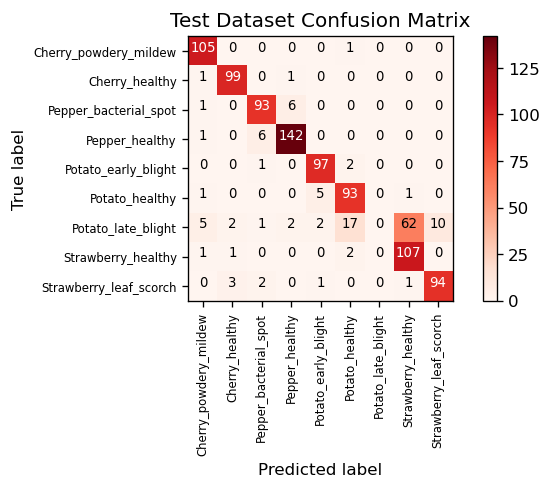

In [79]:
plot_confusion_matrix(test_confusion_matrix,class_names, title = "Test Dataset Confusion Matrix")

### Confusion Matrix Normalized

[[0.9906 0.     0.     0.     0.     0.0094 0.     0.     0.    ]
 [0.0099 0.9802 0.     0.0099 0.     0.     0.     0.     0.    ]
 [0.01   0.     0.93   0.06   0.     0.     0.     0.     0.    ]
 [0.0067 0.     0.0403 0.953  0.     0.     0.     0.     0.    ]
 [0.     0.     0.01   0.     0.97   0.02   0.     0.     0.    ]
 [0.01   0.     0.     0.     0.05   0.93   0.     0.01   0.    ]
 [0.0495 0.0198 0.0099 0.0198 0.0198 0.1683 0.     0.6139 0.099 ]
 [0.009  0.009  0.     0.     0.     0.018  0.     0.964  0.    ]
 [0.     0.0297 0.0198 0.     0.0099 0.     0.     0.0099 0.9307]]


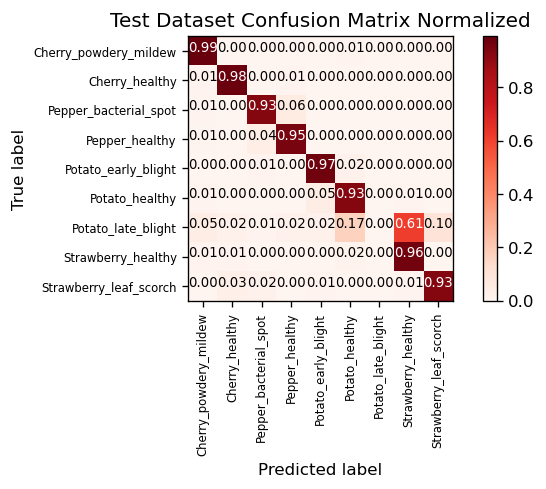

In [78]:
plot_confusion_matrix(test_confusion_matrix_norm,class_names,title = "Test Dataset Confusion Matrix Normalized",is_normalized=True)

[[104   0   0   0   0   1   0   0   0]
 [  0  99   0   0   0   0   0   0   1]
 [  1   1  93   3   1   1   0   0   0]
 [  0   1   4 141   0   1   0   0   0]
 [  1   0   1   1  96   1   0   0   0]
 [  0   0   1   1   3  95   0   0   0]
 [  6   7   0   5   4  10   0  62   6]
 [  1   0   0   0   2   0   0 108   0]
 [  1   0   2   1   0   0   0   0  96]]


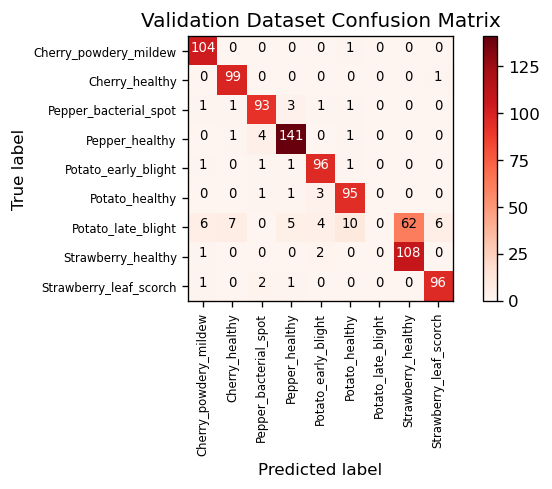

In [80]:
plot_confusion_matrix(val_confusion_matrix,class_names, title = "Validation Dataset Confusion Matrix")

[[0.9905 0.     0.     0.     0.     0.0095 0.     0.     0.    ]
 [0.     0.99   0.     0.     0.     0.     0.     0.     0.01  ]
 [0.01   0.01   0.93   0.03   0.01   0.01   0.     0.     0.    ]
 [0.     0.0068 0.0272 0.9592 0.     0.0068 0.     0.     0.    ]
 [0.01   0.     0.01   0.01   0.96   0.01   0.     0.     0.    ]
 [0.     0.     0.01   0.01   0.03   0.95   0.     0.     0.    ]
 [0.06   0.07   0.     0.05   0.04   0.1    0.     0.62   0.06  ]
 [0.009  0.     0.     0.     0.018  0.     0.     0.973  0.    ]
 [0.01   0.     0.02   0.01   0.     0.     0.     0.     0.96  ]]


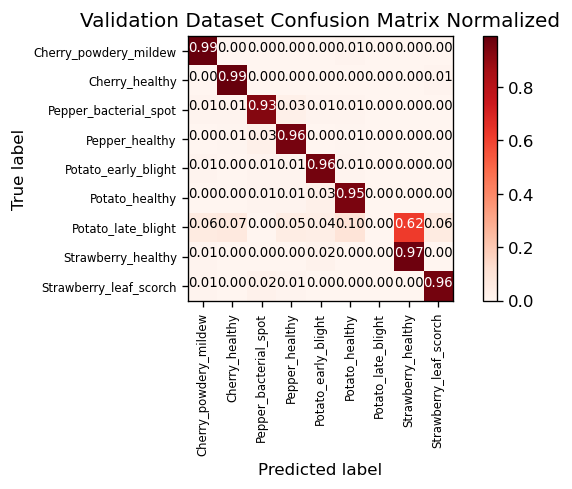

In [81]:
plot_confusion_matrix(val_confusion_matrix_norm,class_names,title = "Validation Dataset Confusion Matrix Normalized",is_normalized=True)

In [50]:
#fetching jobname , client and description to be used for plotting.
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [51]:
print(f"Jobname: {job_name}")
print(f"Client: {client}")
print(f"Description: {description}")

Jobname: pytorch-training-2022-01-24-07-46-57-185
Client: <botocore.client.SageMaker object at 0x7fe035cf8898>
Description: {'TrainingJobName': 'pytorch-training-2022-01-24-07-46-57-185', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:970845818811:training-job/pytorch-training-2022-01-24-07-46-57-185', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-970845818811/pytorch-training-2022-01-24-07-46-57-185/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '64', 'epochs': '"5"', 'lr': '"0.00033327270100541676"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2022-01-24-07-46-57-185"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-970845818811/pytorch-training-2022-01-24-07-46-57-185/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.us-east-1

In [53]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
#creating a trial
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-01-24 08:12:43.764 ip-172-16-11-65:23763 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-970845818811/pytorch-training-2022-01-24-07-46-57-185/debug-output
[2022-01-24 08:12:44.068 ip-172-16-11-65:23763 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4782 more expected)', IncompleteRead(0 bytes read, 4782 more expected)) while reading s3://sagemaker-us-east-1-970845818811/pytorch-training-2022-01-24-07-46-57-185/debug-output/index/000000000/000000000128_worker_0.json . Will retry now


In [54]:
trial.tensor_names() #all the tensor names

[2022-01-24 08:12:47.633 ip-172-16-11-65:23763 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-24 08:12:48.660 ip-172-16-11-65:23763 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [55]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))

61

In [56]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))

96

## Plot CrossEntropy Loss Tensor for Visualization purposes

In [57]:
#Defining some utility functions to be used for plotting tensors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


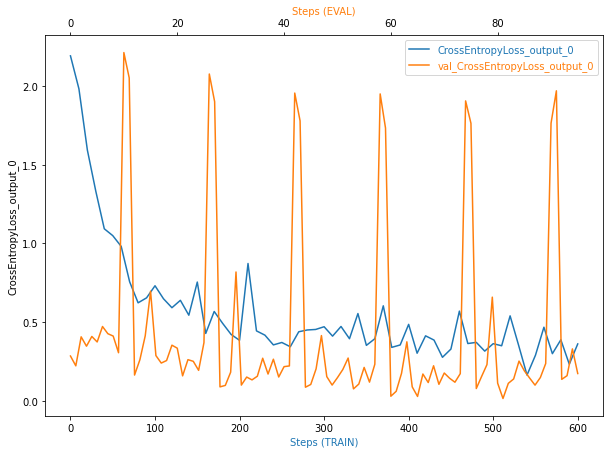

In [58]:
#plotting the tensor
plot_tensor(trial, "CrossEntropyLoss_output_0")

**There is anomalous behaviour of not getting smooth output lines.
* **How would I go about fixing the anomalous behaviour?**
  * Making some adjustments in the pretrained model to use a different set of the fully connected layers network, ideally should help to smoothen out the graph.**
  * If I had more AWS credits, then would have changed the fc layers used in the model. Firstly would try by adding in one more fc layer on top of the existing two layers and check the results, and then if the results didn't improve much then would try by removing all the fc layers and keeping only one fc layer in the model and then rerun the tuning and training jobs and check the outputs

###  Display the profiler output

In [59]:
#  Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report location: {rule_output_path}")

Profiler report location: s3://sagemaker-us-east-1-970845818811/pytorch-training-2022-01-24-07-46-57-185/rule-output


In [60]:
! aws s3 ls {rule_output_path} --recursive

2022-01-24 07:57:34     392454 pytorch-training-2022-01-24-07-46-57-185/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-24 07:57:33     243738 pytorch-training-2022-01-24-07-46-57-185/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-24 07:57:29        191 pytorch-training-2022-01-24-07-46-57-185/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-24 07:57:29       7205 pytorch-training-2022-01-24-07-46-57-185/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-24 07:57:29        126 pytorch-training-2022-01-24-07-46-57-185/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-24 07:57:29        129 pytorch-training-2022-01-24-07-46-57-185/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-24 07:57:29       4013 pytorch-training-2022-01-24-07-46-57-185/rule-output/ProfilerReport/profiler-output/profiler-re

In [61]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-970845818811/pytorch-training-2022-01-24-07-46-57-185/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-970845818811/pytorch-training-2022-01-24-07-46-57-185/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-970845818811/pytorch-training-2022-01-24-07-46-57-185/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-970845818811/pytorch-training-2022-01-24-07-46-57-185/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-9708458

In [62]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [88]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [64]:
# Zipping the ProfilerReport inorder to export and upload it later for submission
import shutil
shutil.make_archive("./profiler_report.zip", "zip", "ProfilerReport")

'/home/ec2-user/SageMaker/AWS-MLE-Capstone-project/profiler_report.zip.zip'

## Model Deploying

* Upon reading the docs, understood that for model deployment purposes we need to create a separate inference script, and override a few functions.
* Given the ideal and recommended approach was to create an endpoint inference script and use that to deploy the saved model from the previous training job, so went ahead and implemented that.
* References: https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#deploy-pytorch-models

In [65]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

#Below is the s3 location of our saved model that was trained by the training job using the best hyperparameters
model_data_artifacts = "s3://sagemaker-us-east-1-970845818811/pytorch-training-2022-01-24-07-46-57-185/output/model.tar.gz"

#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

#If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_data_artifacts,
                             role = role,
                             entry_point= "endpoint_inference.py",
                             py_version = "py36",
                             framework_version = "1.6",
                            predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.t2.medium") #Using ml.t2.medium to save costs


---------------!

## Free-form visualizations - Testing deployed model on Test Images

Test image no: 1
Below is the image that we will be testing:


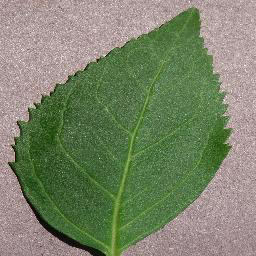

Expected plant category no : 1
Response: [[5.915297031402588, 4.063858509063721, 2.2202095985412598, 4.932678699493408, 0.0, 2.055504560470581, 0.0, 0.7813766598701477, 0.0]]
Response/Inference for the above image is : [1]
Test image no: 2
Below is the image that we will be testing:


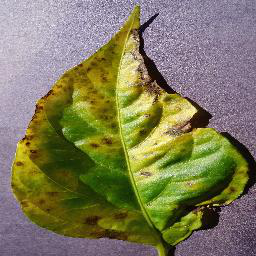

Expected plant category no : 3
Response: [[4.695102214813232, 0.0, 1.5558501482009888, 4.568674564361572, 0.0, 6.158201217651367, 0.0, 0.0, 0.0]]
Response/Inference for the above image is : [6]
Test image no: 3
Below is the image that we will be testing:


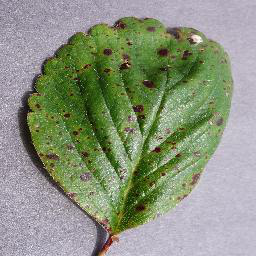

Expected plant category no : 5
Response: [[3.7110848426818848, 0.0, 0.0, 1.7970587015151978, 4.868965148925781, 0.0, 0.0, 1.0674347877502441, 0.0]]
Response/Inference for the above image is : [5]
Test image no: 4
Below is the image that we will be testing:


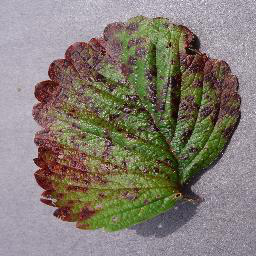

Expected plant category no : 9
Response: [[ 2.083310842514038, 0.0, 0.0, 0.5309632420539856, 0.0, 3.3217852115631104, 0.0, 2.7231500148773193,4.281521797180176]]
Response/Inference for the above image is : [9]


In [73]:
#Testing the deployed endpoint using some test images
#Solution 1: Using the Predictor object directly.
from PIL import Image
import io
import os
import numpy as np

test_dir = "./testImages"
test_images = [ "cherry_healthy.JPG",'pepper_bell_bacteria.JPG', 'potato_early_blight.JPG', 'strawberry_leaf_scortch.JPG' ]
test_images_expected_output = [ 1, 3,5, 9 ]
for index in range(len(test_images) ):
    test_img = test_images[index]
    expected_plant_category = test_images_expected_output[index]
    print(f"Test image no: {index+1}")
    test_file_path = os.path.join(test_dir,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print("Below is the image that we will be testing:")
        display(Image.open(io.BytesIO(payload)))
        print(f"Expected plant category no : {expected_plant_category}")
        response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
        print(f"Response: {response}")
        predicted_plant_category = np.argmax(response,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f"Response/Inference for the above image is : {predicted_plant_category}")

**As could be seen from the above 4 tests, that the model seems to be performing good, as out of the 4 test samples it was abe to correctly predict 3 of them.**

In [59]:
# #using Pytorch attach to re create an estimator from the previously created training job, so we don't need to redo the training
# from sagemaker.pytorch import PyTorch
# training_job_name = 'pytorch-training-2021-12-15-12-06-44-446'
# pytorch_estimator = PyTorch.attach(training_job_name)


2021-12-15 12:21:30 Starting - Preparing the instances for training
2021-12-15 12:21:30 Downloading - Downloading input data
2021-12-15 12:21:30 Training - Training image download completed. Training in progress.
2021-12-15 12:21:30 Uploading - Uploading generated training model
2021-12-15 12:21:30 Completed - Training job completed


In [24]:
print(predictor.endpoint_name)
endpoint_name = predictor.endpoint_name

pytorch-inference-2021-12-16-06-09-09-307


In [45]:
best_hyperparameters = {'batch_size': 64, 'lr': '0.00033327270100541676', 'epochs': '5'}
print(best_hyperparameters)
# temp_hyperparameters = {'batch_size': 64, 'lr': '0.00033327270100541676', 'epochs': '5'}

{'batch_size': 64, 'lr': '0.00033327270100541676', 'epochs': '5'}


In [63]:
# Uncomment and Using below to setup a predictor object if we have an active endpoint.
# predictor = Predictor( endpoint_name =  "pytorch-inference-2021-12-15-18-27-06-266" )

In [90]:
# Remember to shutdown/delete your endpoint once your work is done
# predictor.delete_endpoint()

In [ ]:
# from sagemaker.pytorch import PyTorch
# # Create and fit an estimator
# estimator = PyTorch(
#     entry_point="train_model.py",
#     source_dir = "code",
#     instance_count=1,
#     instance_type="ml.g4dn.xlarge",
#     role=role,
#     framework_version="1.6", #using 1.6 as it has support for smdebug lib , https://github.com/awslabs/sagemaker-debugger#debugger-supported-frameworks
#     py_version="py36",
#     hyperparameters=temp_hyperparameters,
# )

# predictor = estimator.fit({'train' : inputs },wait=True)